### Analysis of Time Series I: Power Spectral Densities & Filtering

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import numpy.random as rng
rng.seed(12093)

from numpy import fft as npf
from scipy import signal as sps

from astroML.datasets import fetch_rrlyrae_templates
templates = fetch_rrlyrae_templates()
from astroML.datasets import fetch_LIGO_large


The *AstroML* package is the companion to the book *Statistics, Data Mining, and Machine Learning in Astronomy* by
Ivezic, Connolly, VanderPlas, and Gray (Princeton, 2014). One can install it in Anaconda Python with   
```conda install -c AstroMl```

From it, we will obtain the lightcurve of an RR Lyrae variable star (or at least a non-dimensionalized version thereof). We'll stack two together so as to have two periods of data, and invert the y-axis (damn magnitudes!):

In [2]:
x, y = templates['115r'].T
y = 1 - y
N = len(x)

Text(0.5, 0, 'phase')

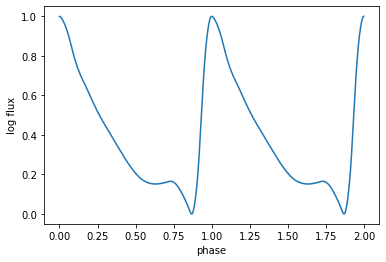

In [3]:
fig, ax = plt.subplots()
ax.plot(np.hstack((x,1+x)),np.hstack((y,y)))
ax.set_ylabel('log flux')
ax.set_xlabel('phase')

Now let's plot it's power spectral density (PSD), defined for a function $g(t)$ as   

$$ \textrm{PSD}(g) = |G(f)|^2 + |G(f)|^2 $$
where $G$ is the Fourier transform of $g$.

The discrete version is   

$$ \mathrm{PSD}(f_k) = (\Delta t)^2 (|G[k]|^2 + |G[N-k]|^2) $$


Since the Fourier transform of a real function is symmetric about zero frequency, we can just take   

$$ \textrm{PSD}(\nu) = 2 |F(\nu)|^2 $$

and since the standard ordering of frequencies starts at zero and reaches the Nyquist frequency at half the length of the FFT:

In [4]:
npf.fftfreq(10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

we can consider just the first half of the FFT:

In [5]:
def PSD(t, data):
    nt = t.shape[0]
    nk = nt//2
    dt = t[1] - t[0]
    dk = 1. / (nt * dt)
    k = dk * np.arange(nk)
    return k, np.abs(npf.fft(data-data.mean()))[:nk]/nk

(0.0, 15.0)

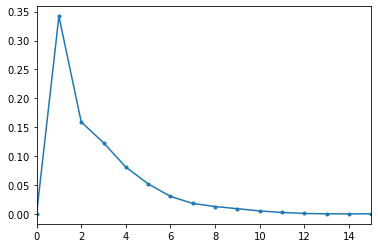

In [6]:
k, psd = PSD(x, y)
fig, ax = plt.subplots()
ax.plot(k,psd, '.-')
ax.set_xlim(0,15)

or, plotting as a function of period

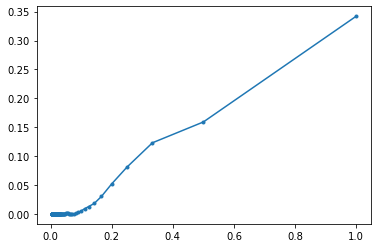

In [7]:
fig, ax = plt.subplots()
ax.plot(1/k[:0:-1],psd[:0:-1], '.-')

From this we can see that the power falls off pretty quickly with increasing frequency or decreasing period.

If we low-pass filter the data, we get a sequence of approximations using 1, 4, & 7 Fourier modes:

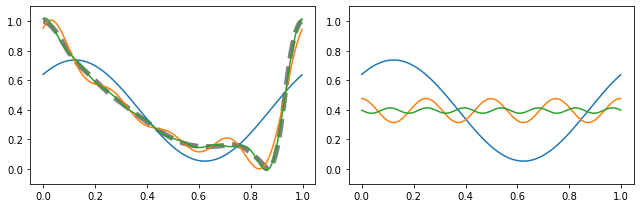

In [8]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].set_ylim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)

Y = npf.fft(y)

for i in range(1,10,3):
    yf = Y.copy()
    # set all but +/- the first i frequencies to zero
    yf[i+1:-i] = 0
    yp = npf.ifft(yf).real
    ax[0].plot(x, yp)
    # set only frequencies +/- i and the DC component
    yf[:] = 0
    yf[i] = Y[i]
    yf[-i] = Y[-i]
    yf[0] = Y[0]
    yp = npf.ifft(yf).real
    ax[1].plot(x, yp)
ax[0].plot(x,y, 'k--', lw=5, alpha=0.5, zorder=0)
fig.tight_layout()

It should be no surprise that modeling time sequences of data as a small number of Fourier modes can be quite effective, at least for smoothly-varying functions.

Of course, the FFT requires that we sample the data uniformly in time. Let's simulate doing this by generating a sine wave as our signal, but zeroing out all of the data except at some randomly-chosen subset of times. Note that there is no noise in this example, only cloudy nights, TAC's, and the like:

In [9]:
N = 2 ** 16
Nobs = 40

# make sin wave signal with frequency 30
t = np.linspace(0, 1, N)
dt = t[1] - t[0]
s = np.sin(2*np.pi * t * 30)

# pick random indices as observations
rng.seed(433487)
indx = (N*rng.rand(Nobs)).astype('int')
to = t[indx]
yo = s[indx]

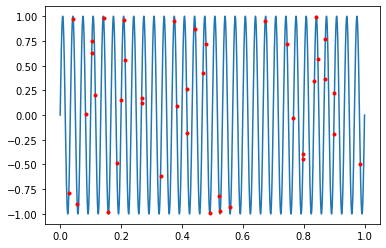

In [10]:
fig, ax = plt.subplots()
ax.plot(t, s)
ax.plot(to, yo, 'r.')

The PSD of the signal is of course just a single spike at 30:

(0.0, 1000.0)

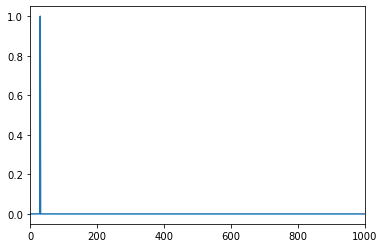

In [11]:
k, psd = PSD(t, s)
fig, ax = plt.subplots()
ax.plot(k, psd)
ax.set_xlim(0,1000)

The *window function* is a set of $\delta$ functions at the observation times, so the observations are the window
function multiplied by the signal. In our discrete case, these delta functions are top-hat functions of width $\Delta t$ and amplitude $1/\Delta t$.

The PSD of the window function is thus

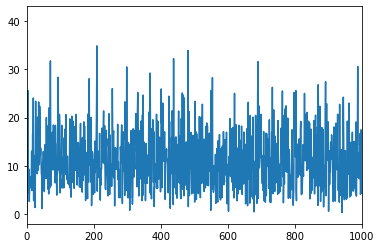

In [12]:
window = np.zeros_like(t)
window[indx] = 1/dt

k, psdw = PSD(t, window)
fig, ax = plt.subplots()
ax.plot(k, psdw)
ax.set_xlim(0, 1000);

If we take the PSD of the observations, we find that a lot of the power is aliased into other frequencies:

(0.0, 1000.0)

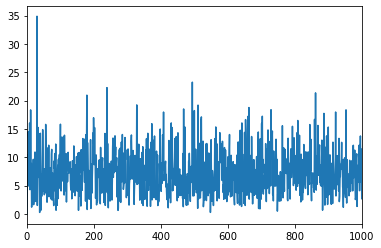

In [13]:
fig, ax = plt.subplots()
k, psdd = PSD(t, s*window)
ax.plot(k, psdd)
ax.set_xlim(0,1000)

There is clearly a strong signal at a frequency of 30, but there are at least a half-dozen other peaks more than half as strong at higher frequencies. By comparing the power spectrum of the window function with that of the data,
one can begin to undertand the aliasing behavior of the unevenly-sampled data.

The discussion so far has ignored noise in the data. Let's try adding significant noise

In [14]:
N = 2 ** 16
Nobs = 40

# make sin wave signal with frequency 30
t = np.linspace(0, 1, N)
dt = t[1] - t[0]
s = np.sin(2*np.pi * t * 30) + 0.5*rng.randn(t.shape[0])

# pick random indices as observations
rng.seed(433487)
indx = (N*rng.rand(Nobs)).astype('int')
to = t[indx]
yo = s[indx]

window = np.zeros_like(t)
window[indx] = 1/dt

(0.0, 1000.0)

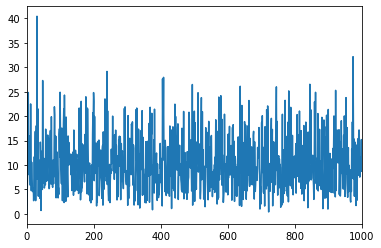

In [15]:
fig, ax = plt.subplots()
k, psdd = PSD(t, s*window)
ax.plot(k, psdd)
ax.set_xlim(0,1000)

Welch's method compute the power spectral density by dividing the time-domain signal into equal-length segments,
taking the PSD of each, and then averaging the results. The result is a PSD less affected by noise in the signal.

More specifically, it divides the $N$ observations $s_i$ into $K$ segments of length $M$ by multiplying by a sliding window function over the signal
$w(t)$
$$ S_j(i) = w_i s_{i+jR},\ i=0,\dots,M-1, \ j=0,\dots,K-1 $$
where $R$ is the *hop size*.

If the window function is a top-hat of length $M$, the segments usually do not overlap and $R=M$, $K=N/M$.
A simple implementation is

In [16]:
def Welch(s, dt, M):
    N = s.shape[0]
    K = N//M
    print(f"{K} segments")
    fsum = np.zeros(M//2, dtype='complex128')
    for i in range(K):
        seg = np.zeros(M)
        seg[0:M] = s[i*M:(i+1)*M]
        psdseg = np.abs(npf.fft(seg))/(M//2)
        fsum += psdseg[0:M//2]**2
        
    fsum /= K
    
    df = 1. / (M * dt)
    f = df * np.arange(M / 2)
    
    return f, fsum.real

We can apply this to 2048 seconds of LIGO data sampled at 4096 Hz

In [17]:
data, dt = fetch_LIGO_large()

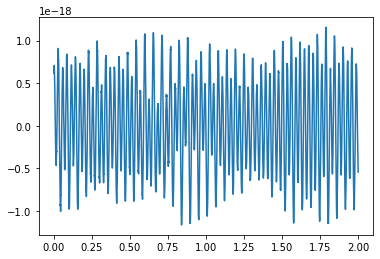

In [18]:
t0 = 646
T = 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

fig, ax = plt.subplots()
ax.plot(tplot,dplot)

Using our PSD function on the data, we have

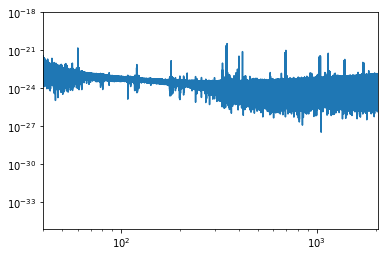

In [19]:
td = dt * np.arange(data.shape[0])
f0, p0 = PSD(td, data)
fig, ax = plt.subplots()
ax.loglog(f0, p0)
ax.set_xlim(40, 2060);

Welch's agorithm gives

In [20]:
f, p = Welch(data, dt, 4096)

2048 segments


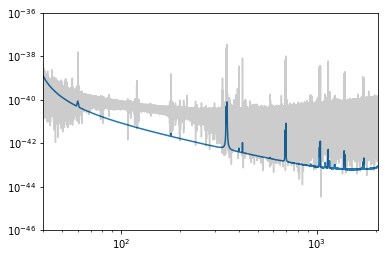

In [21]:
fig, ax = plt.subplots()
ax.loglog(f, p)
ax.loglog(f0, p0/1e17, 'k', alpha=0.2)
ax.set_xlim(40, 2060);
ax.set_ylim(1.e-46, 1.e-36);

We can use Scipy's implementation of Welch's method, using a *Hann window* (to be defined shortly). Using the Hann
window supresses high-frequency noise further, at the expense of distorting the overall shape of the spectrum.
Frequently, however, one is looking for spectral features and doesn't care much about the shape of the "continuum".

In [22]:
fh, ph = sps.welch(data, fs=4096, window='hann', nperseg=4096, noverlap=0, scaling='density')

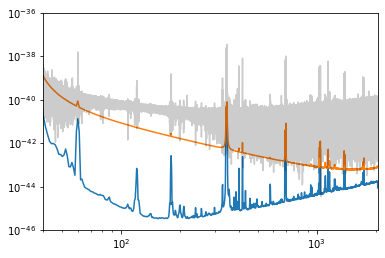

In [23]:
fig, ax = plt.subplots()
ax.loglog(fh, ph)
ax.loglog(f,p)
ax.loglog(f0, p0/1e17, 'k', alpha=0.2)
ax.set_xlim(40, 2060)
ax.set_ylim(1.e-46, 1.e-36);

When using a windowing function, it is well to realize the effects on the spectrum. For example, let's take the Fourier transform of a top-hat filter:

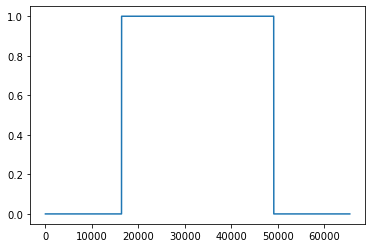

In [24]:
N = 2**16
x = np.arange(N)
tophat = np.where( (x>N//2-N//4) & (x<N//2+N//4), 1, 0)
fig, ax = plt.subplots()
ax.plot(x, tophat)

It's FFT suffers from significant ringing, as would be expected from such a non-smooth function:

(32512.0, 33024.0)

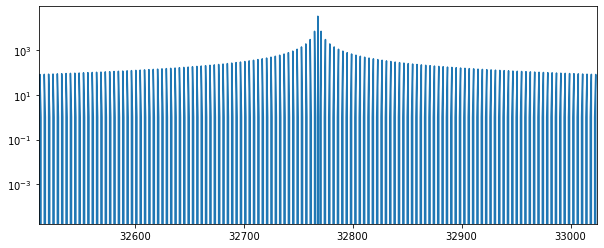

In [25]:
fx = npf.fftshift(npf.fft(tophat).real)
fig, ax = plt.subplots(figsize=(10,4))
ax.semilogy(fx)
ax.set_xlim(N//2-256,N//2+256)

The Hann window function is 
$$w(n) = \sin^2(\frac{\pi n}{N})$$
one of a family of window functions based on trigonometric sums.

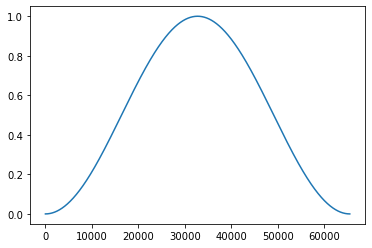

In [26]:
n = np.arange(N)
hann = np.sin(np.pi*n/(N-1))**2
fig,ax = plt.subplots()
ax.plot(hann)

(32512.0, 33024.0)

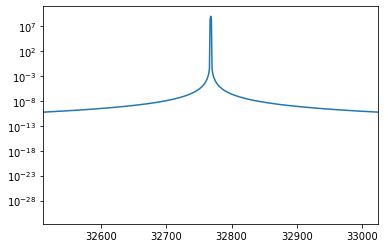

In [27]:
fx = npf.fftshift(npf.fft(hann)).real**2
fig, ax = plt.subplots()
ax.semilogy(fx)
ax.set_xlim(N//2-256,N//2+256)

Let's apply these windows to our frequency-30 signal from above:

In [28]:
N = 2 ** 12

# make sin wave signal with frequency 30
t = np.linspace(0, 1, N)
dt = t[1] - t[0]
s = np.sin(2*np.pi * t * 30)

We'll apply the window to 1/8 of the data.

First the top-hat window:

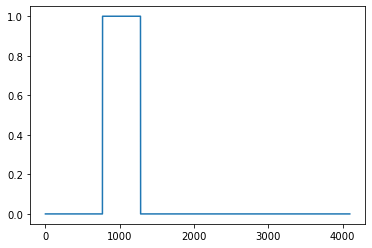

In [29]:
w = N//8
c = N//4
m = np.arange(N)
tophat = np.where( (m>=c-w//2)&(m<c+w//2), 1, 0)
fig, ax = plt.subplots()
ax.plot(tophat)

There are significant side-lobes to the peaks at $f=\pm30$:

(-300.0, 300.0)

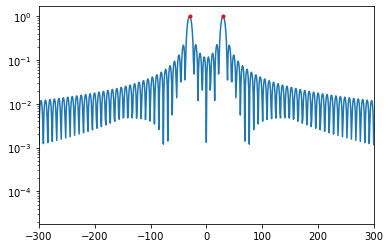

In [30]:
fw = np.abs(npf.fftshift(npf.fft(tophat*s)))
f = npf.fftshift(npf.fftfreq(N,d=1/N))
fig, ax = plt.subplots()
ax.semilogy(f,fw/np.max(fw))
ax.plot([-30,30], [1,1], 'r.')
ax.set_xlim(-300,300)

Now try the Hann window function:

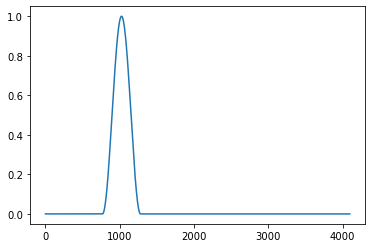

In [31]:
m = np.arange(N)
hann = np.where((m>=c-w//2)&(m<c+w//2), np.sin(np.pi*(m-c+w//2)/w)**2, 0)
fig, ax = plt.subplots()
ax.plot(hann)

With the Hann window, the peaks are significant broader, but the sidelobes are suppressed significantly:

(-300.0, 300.0)

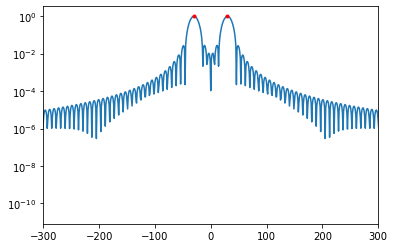

In [32]:
fw = np.abs(npf.fftshift(npf.fft(hann*s)))
fig, ax = plt.subplots()
ax.semilogy(f,fw/np.max(fw))
ax.plot([-30,30], [1,1], 'r.')
ax.set_xlim(-300,300)

When using a windowing function like Hann, Welch's method frequently is used with overlapping samples to increase the degree of averaging,

In [33]:
fh0, ph0 = sps.welch(data, fs=4096, window='hann', nperseg=4096, noverlap=2048, scaling='density')

With the LIGO data, there are already so many samples that this makes little difference:

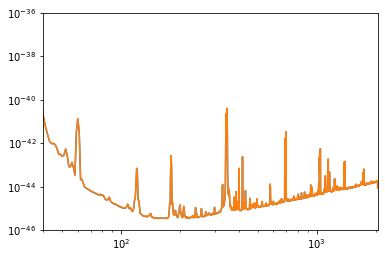

In [34]:
fig, ax = plt.subplots()
ax.loglog(fh, ph)
ax.loglog(fh0, ph0)
ax.set_xlim(40, 2060)
ax.set_ylim(1.e-46, 1.e-36);

An obvious taks in filtering is removing noise from a signal. It is always important to remember that *all* forms of filtering can only *remove* information. There is, however, a great deal of information (high entropy) in noise; its just not information we care about. That is why we call it "noise" in the first place!

Consider some "true" signal $u(t)$ which is "corrupted" in two ways. The first is that the measurement process distorts the signal, so that the true signal $u(t)$ is convolved with some function
$$ s(t) = \int_{-\infty}^\infty r(t-\tau) u(\tau) d\tau $$
or, in Fourier space,
$$ S(f) = R(f)U(f) $$
where $s$ stands for "smeared" in some sense.

In the absence of noise, we know how to deal with this. Measure the response function $r(t)$ (*e.g.* the psf of a telescope) and *deconvolve* it from the signal:
$$ U(f) = \frac{S(f)}{R(f)} $$

In the presence of noise, this becomes more complicated, as the deconvolution will "sharpen" up the noise as well as the signal. We want an a filter which is optimal (in some sense) such that we can write
$$ \tilde{U}(f) = \frac{S(f) \Phi(f)}{R(f)} $$
and the resulting etimate of $\tilde{U}$ of $U$ is as close as possible to the underlying signal.

Norbert Wiener considered the case where "close" is defined in the mean-square sense of minimizing
$$ \int_{-\infty}^\infty |\tilde{u}(t)-u(t)|^2 dt = \int_{-\infty}^\infty |\tilde{U}(f)-U(f)|^2 dt $$

If we say that our corrupted signal is $c(t) = s(t) + n(t)$ where $n(t)$ is noise of some sort, this corresponds to
minimizing   

\begin{align}
\phantom{=}&\int_{-\infty}^\infty \left| \frac{[S(F)+N(f)]\Phi(f)}{R(f)} - \frac{S(f)}{R(f)} \right|^2 df \\
= &
\int_{-\infty}^\infty |R(f)|^{-2} \left[|S(f)|^2 |1-\Phi(f)|^2 + |N(f)|^2|\Phi(f)|^2\right] df
\end{align}

We have assumed in the second step that the signal and the noise are uncorrelated; this is by far the most common case. The integral will be minimized if we minimize the integrand with respect to $\Phi(f)$ at every frequency,
with the result that 
$$ \Phi(f) = \frac{|S(f)|^2}{|S(f)|^2 + |N(f)|^2} $$

Note that this expression does not depend upon our knowing the true singnal $U$ in advance. (This is known as an 
*acausal* Wiener filter, since it relys upon future information to determine the filter at each time; other variations exist which use only past information, so-called *causal* filters most often used in real-time applications.)

How do we estimate $|S(f)|^2$ and $|N(f)|^2$? These are both PSD's, and if we make at least some crude assumption we can often do quite well.

Consider some noisy, smoothed data data:

In [96]:
def ufunc(t):
    return np.sin(2*np.pi * 3 * t)**6

def rfunc(t, u, dt, w):
    gt = np.arange(-3*w, 3*w, dt)
    gaussian = np.exp(-(gt/w)**2/2)/(np.sqrt(2*np.pi)*w)/u.shape[0]
    print(u.shape, gaussian.shape)
    return np.convolve(u, gaussian, mode="same")

def nfunc(t, sig):
    return sig * rng.randn(t.shape[0])

(256,) (31,)


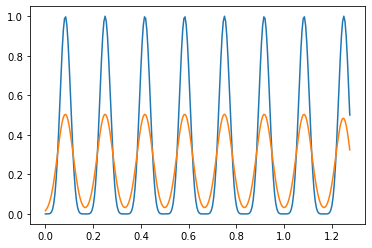

In [97]:
N = 2**8
dt = 0.005
t = dt * np.arange(N)
u = ufunc(t)
s = rfunc(t, u, dt, 5*dt)

fig, ax = plt.subplots()
ax.plot(t, u)
ax.plot(t, s)

In [103]:
c = s + nfunc(t, 0.1)

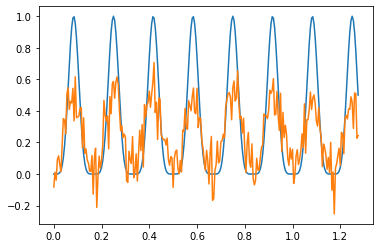

In [104]:
fig, ax = plt.subplots()
ax.plot(t, u)
ax.plot(t, c)

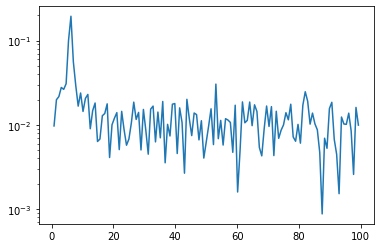

In [107]:
f, p = PSD(t, c)
fig, ax = plt.subplots()
ax.semilogy(f[1:], p[1:])